# Phase 2-----(step 1.2[Deep EDA Analysis])

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from EDA_Detection.cleaning_func import reduce_mem_usage
import numpy as np
import warnings
import gc
from file_path import TRAIN_ID,TRAIN_TRANS

warnings.filterwarnings('ignore')

### Define the columns we want to KEEP

In [4]:
trans_cols_to_keep = [
    'TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
    'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'dist1', 'dist2'
]
# Add C, D, and M columns
trans_cols_to_keep.extend([f'C{i}' for i in range(1, 15)])
trans_cols_to_keep.extend([f'D{i}' for i in range(1, 16)])
trans_cols_to_keep.extend([f'M{i}' for i in range(1, 10)])

# Define dtypes for the columns we are keeping (using float32 for compatibility)
dtypes_trans_essentials = {
    'TransactionAmt': 'float32', 'isFraud': 'int8', 'TransactionDT': 'int32',
    'TransactionID': 'int32', 'ProductCD': 'category', 'card1': 'int16',
    'card2': 'float32', 'card3': 'float32', 'card4': 'category',
    'card5': 'float32', 'card6': 'category', 'addr1': 'float32',
    'addr2': 'float32', 'dist1': 'float32', 'dist2': 'float32',
    'P_emaildomain': 'category', 'R_emaildomain': 'category'
}
dtypes_trans_essentials.update({col: 'float32' for col in [f'C{i}' for i in range(1, 15)]})
dtypes_trans_essentials.update({col: 'float32' for col in [f'D{i}' for i in range(1, 16)]})
dtypes_trans_essentials.update({col: 'category' for col in [f'M{i}' for i in range(1, 10)]})


## --- Load and Optimize Essential Data ---

In [5]:
print("Loading train_transaction.csv (ESSENTIAL COLUMNS ONLY)...")
# Use 'usecols' to restrict columns loaded
train_trans = pd.read_csv(TRAIN_TRANS, dtype=dtypes_trans_essentials, usecols=trans_cols_to_keep)
train_trans = reduce_mem_usage(train_trans)  # Optimize memory AFTER loading

print("\nLoading train_identity.csv...")
# Identity file is smaller, load it fully and then optimize
train_id = pd.read_csv(TRAIN_ID, dtype={'TransactionID': 'int32'})
train_id = reduce_mem_usage(train_id)

print("\nMerging dataframes...")
train_data = train_trans.merge(train_id, on='TransactionID', how="left")

# Clean up memory
del train_trans, train_id
gc.collect()


Loading train_transaction.csv (ESSENTIAL COLUMNS ONLY)...
Initial Memory usage: 97.44 MB
Final Memory usage: 55.76 MB (Decreased by 42.8%)

Loading train_identity.csv...
Initial Memory usage: 44.57 MB
Final Memory usage: 9.72 MB (Decreased by 78.2%)

Merging dataframes...


0

## --- 1. Transaction Amount by Fraud ---


=== TRANSACTION AMOUNT ANALYSIS ===

Legitimate Transactions:
count    569877.000000
mean               NaN
std           0.000000
min           0.250977
25%          43.968750
50%          68.500000
75%         120.000000
max       31936.000000
Name: TransactionAmt, dtype: float64

Fraudulent Transactions:
count    2.066300e+04
mean              inf
std      2.322500e+02
min      2.919922e-01
25%      3.503125e+01
50%      7.500000e+01
75%      1.610000e+02
max      5.192000e+03
Name: TransactionAmt, dtype: float64


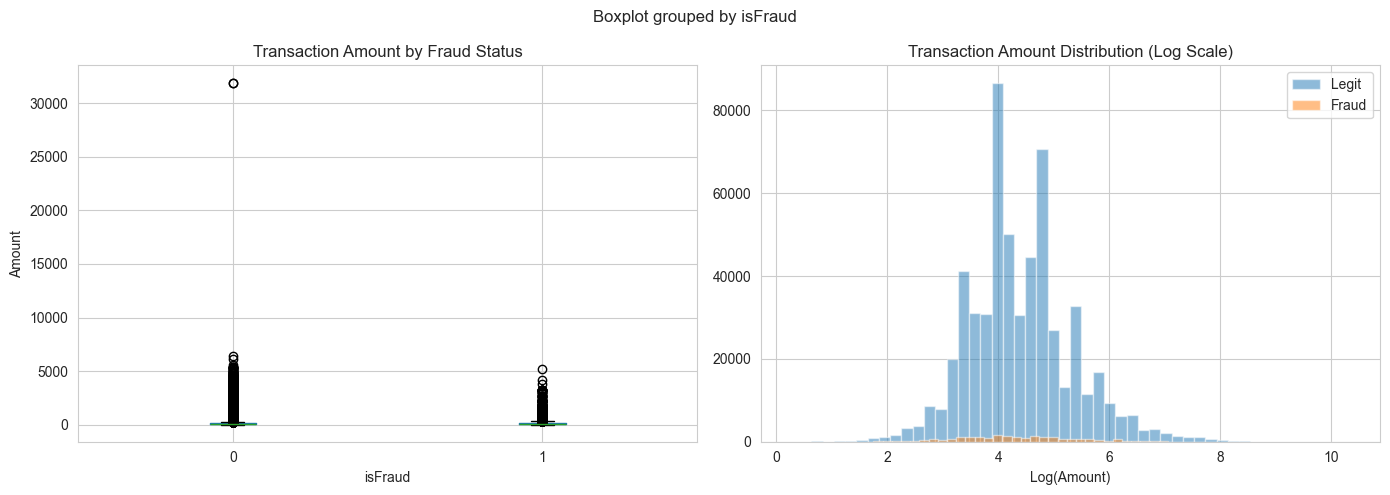

In [6]:
# set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# --- 1. Transaction Amount by Fraud ---
print("\n=== TRANSACTION AMOUNT ANALYSIS ===")
print("\nLegitimate Transactions:")
print(train_data[train_data['isFraud']==0]['TransactionAmt'].describe())
print("\nFraudulent Transactions:")
print(train_data[train_data['isFraud']==1]['TransactionAmt'].describe())

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
train_data.boxplot(column='TransactionAmt', by='isFraud', ax=axes[0])
axes[0].set_title('Transaction Amount by Fraud Status')
axes[0].set_xlabel('isFraud')
axes[0].set_ylabel('Amount')

# Distribution (log scale to see better)
train_data[train_data['isFraud']==0]['TransactionAmt'].apply(np.log1p).hist(bins=50, alpha=0.5, label='Legit', ax=axes[1])
train_data[train_data['isFraud']==1]['TransactionAmt'].apply(np.log1p).hist(bins=50, alpha=0.5, label='Fraud', ax=axes[1])
axes[1].set_title('Transaction Amount Distribution (Log Scale)')
axes[1].set_xlabel('Log(Amount)')
axes[1].legend()
plt.tight_layout()
plt.show()


## --- 2. Product Type Analysis ---


=== PRODUCT TYPE ANALYSIS ===

Fraud rate by ProductCD:
           Fraud_Count  Total_Trans  Fraud_Rate
ProductCD                                      
C                 8008        68519      0.1169
S                  686        11628      0.0590
H                 1574        33024      0.0477
R                 1426        37699      0.0378
W                 8969       439670      0.0204


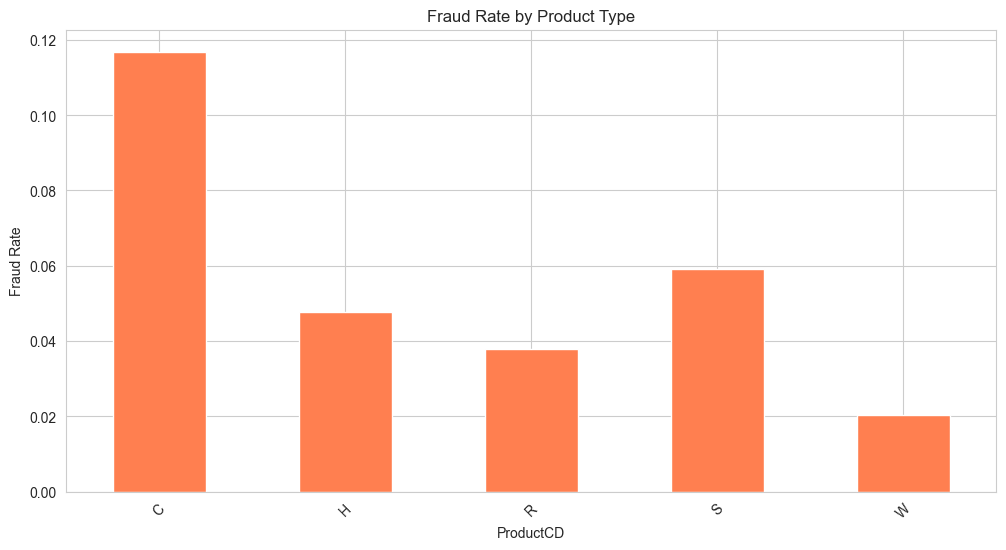

In [7]:
print("\n=== PRODUCT TYPE ANALYSIS ===")
print("\nFraud rate by ProductCD:")
fraud_by_product = train_data.groupby('ProductCD')['isFraud'].agg(['sum', 'count', 'mean']).round(4)
fraud_by_product.columns = ['Fraud_Count', 'Total_Trans', 'Fraud_Rate']
print(fraud_by_product.sort_values('Fraud_Rate', ascending=False))

# Visualization
fraud_by_product['Fraud_Rate'].plot(kind='bar', color='coral')
plt.title('Fraud Rate by Product Type')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45)
plt.show()


## --- 3. Card Type Analysis (card4, card6) ---

In [8]:
print("\n=== CARD TYPE ANALYSIS ===")
print("\nFraud rate by card4 (card brand):")
print(train_data.groupby('card4')['isFraud'].mean().sort_values(ascending=False).head(10))

print("\nFraud rate by card6 (card type):")
print(train_data.groupby('card6')['isFraud'].mean().sort_values(ascending=False).head(10))


=== CARD TYPE ANALYSIS ===

Fraud rate by card4 (card brand):
card4
discover            0.077282
visa                0.034756
mastercard          0.034331
american express    0.028698
Name: isFraud, dtype: float64

Fraud rate by card6 (card type):
card6
credit             0.066785
debit              0.024263
debit or credit    0.000000
charge card        0.000000
Name: isFraud, dtype: float64


## --- 4. Email Domain Analysis ---

In [9]:
print("\n=== EMAIL DOMAIN ANALYSIS ===")
print("\nTop email domains for fraud:")
fraud_emails = train_data[train_data['isFraud']==1]['P_emaildomain'].value_counts().head(10)
print(fraud_emails)

print("\nFraud rate by email domain (top 10):")
email_fraud = train_data.groupby('P_emaildomain')['isFraud'].agg(['sum', 'count', 'mean'])
email_fraud = email_fraud[email_fraud['count'] > 100]  # Only domains with enough data
print(email_fraud.sort_values('mean', ascending=False).head(10))



=== EMAIL DOMAIN ANALYSIS ===

Top email domains for fraud:
P_emaildomain
gmail.com        9943
hotmail.com      2396
yahoo.com        2297
anonymous.com     859
aol.com           617
outlook.com       482
comcast.net       246
icloud.com        197
mail.com          106
msn.com            90
Name: count, dtype: int64

Fraud rate by email domain (top 10):
                 sum   count      mean
P_emaildomain                         
mail.com         106     559  0.189624
outlook.es        57     438  0.130137
aim.com           40     315  0.126984
outlook.com      482    5096  0.094584
hotmail.es        20     305  0.065574
live.com.mx       41     749  0.054740
hotmail.com     2396   45250  0.052950
gmail.com       9943  228355  0.043542
yahoo.fr           5     143  0.034965
embarqmail.com     9     260  0.034615


## --- 5. Time Pattern Analysis ---


=== TIME PATTERN ANALYSIS ===

Fraud rate by hour of day:
hour
0     0.031380
1     0.031314
2     0.037483
3     0.038314
4     0.051890
5     0.070302
6     0.077743
7     0.106102
8     0.093014
9     0.089956
10    0.053212
11    0.038816
12    0.030439
13    0.022889
14    0.024216
15    0.025399
16    0.029511
17    0.031530
18    0.035231
19    0.034738
20    0.034273
21    0.034005
22    0.032694
23    0.036997
Name: isFraud, dtype: float64


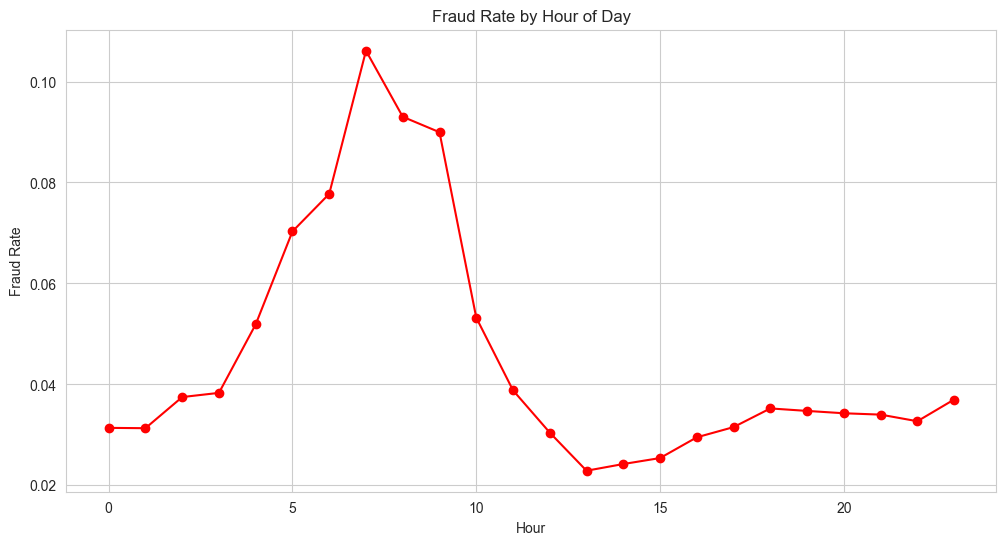

In [10]:
print("\n=== TIME PATTERN ANALYSIS ===")
# TransactionDT is seconds from reference point, let's look at patterns

# Create hour of day feature
train_data['hour'] = (train_data['TransactionDT'] // 3600) % 24

print("\nFraud rate by hour of day:")
hourly_fraud = train_data.groupby('hour')['isFraud'].mean()
print(hourly_fraud)

# Visualization
hourly_fraud.plot(kind='line', marker='o', color='red')
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Fraud Rate')
plt.grid(True)
plt.show()

## --- 6. Missing Value Pattern ---

In [11]:
print("\n=== MISSING VALUE INSIGHTS ===")
print("\nDoes having missing email indicate fraud?")
train_data['email_missing'] = train_data['P_emaildomain'].isnull().astype(int)
print(train_data.groupby('email_missing')['isFraud'].mean())



=== MISSING VALUE INSIGHTS ===

Does having missing email indicate fraud?
email_missing
0    0.036028
1    0.029538
Name: isFraud, dtype: float64
